Import Library

In [1]:
import requests
import geopandas as gpd
import folium
from pyproj import CRS
import pandas as pd

Ambil Data API MapID

In [2]:
urls = {
    "tingkat_polusi": "https://geoserver.mapid.io/layers_new/get_layer?api_key=70b6758f25e94e6a849a32d935bce369&layer_id=6984a42396de9425652debb4&project_id=697e526a949d92a51f0b4816",
    "harga_lahan": "https://geoserver.mapid.io/layers_new/get_layer?api_key=70b6758f25e94e6a849a32d935bce369&layer_id=6984a994bbaa47f3ce684277&project_id=697e526a949d92a51f0b4816",
    "fasilitas_transportasi": "https://geoserver.mapid.io/layers_new/get_layer?api_key=70b6758f25e94e6a849a32d935bce369&layer_id=6984aa4296de9425652ebfad&project_id=697e526a949d92a51f0b4816",
    "fasilitas_pendidikan": "https://geoserver.mapid.io/layers_new/get_layer?api_key=70b6758f25e94e6a849a32d935bce369&layer_id=6984ac32bbaa47f3ce68c2f2&project_id=697e526a949d92a51f0b4816",
    "luas_lahan": "https://geoserver.mapid.io/layers_new/get_layer?api_key=70b6758f25e94e6a849a32d935bce369&layer_id=6984ac502d33abfe646477d1&project_id=697e526a949d92a51f0b4816",
    "ketersediaan_air_bersih": "https://geoserver.mapid.io/layers_new/get_layer?api_key=70b6758f25e94e6a849a32d935bce369&layer_id=6984ac7abbaa47f3ce68c40d&project_id=697e526a949d92a51f0b4816",
    "risiko_banjir": "https://geoserver.mapid.io/layers_new/get_layer?api_key=70b6758f25e94e6a849a32d935bce369&layer_id=6984ac9dbbaa47f3ce68dc4d&project_id=697e526a949d92a51f0b4816",
    "kepadatan_penduduk": "https://geoserver.mapid.io/layers_new/get_layer?api_key=70b6758f25e94e6a849a32d935bce369&layer_id=6984acd196de9425652f4015&project_id=697e526a949d92a51f0b4816"
}

In [3]:
def get_gdf(url):
    response = requests.get(url)
    geojson = response.json()
    return gpd.GeoDataFrame.from_features(geojson["features"])

gdfs = {}

for key, url in urls.items():
    gdfs[key] = get_gdf(url)
    print(f"{key} berhasil diambil")

tingkat_polusi berhasil diambil
harga_lahan berhasil diambil
fasilitas_transportasi berhasil diambil
fasilitas_pendidikan berhasil diambil
luas_lahan berhasil diambil
ketersediaan_air_bersih berhasil diambil
risiko_banjir berhasil diambil
kepadatan_penduduk berhasil diambil


Pemeriksaan dan Penyesuaian Data (Null dan CRS)

In [4]:
for key, gdf in gdfs.items():
    print(key, gdf.crs)

tingkat_polusi None
harga_lahan None
fasilitas_transportasi None
fasilitas_pendidikan None
luas_lahan None
ketersediaan_air_bersih None
risiko_banjir None
kepadatan_penduduk None


In [5]:
for key, gdf in gdfs.items():
    if gdf.crs is None:
        gdf.set_crs(epsg=4326, inplace=True)
    gdfs[key] = gdf

In [6]:
for key, gdf in gdfs.items():
    for col in gdf.columns:
        if gdf[col].dtype == "O":
            gdf[col] = gdf[col].fillna("TIDAK DIKETAHUI")
        else:
            gdf[col] = gdf[col].fillna(0)

Overlay Intersect

In [7]:
result = gpd.overlay(
    gdfs["fasilitas_transportasi"],
    gdfs["harga_lahan"],
    how="intersection"
)

Skoring TOD

In [10]:
print(result.columns)

Index(['ID_1', 'DEKAT_TRANSPORTASI', 'ID_2', 'HARGA_LAHAN', 'geometry'], dtype='str')


In [18]:
result["SKOR_TRANSPORTASI"] = result["DEKAT_TRANSPORTASI"].apply(
    lambda x: 3 if x == "YA" else 1
)

In [20]:
def skor_harga(harga):
    if harga < 250000000:
        return 3
    elif harga < 500000000:
        return 2
    else:
        return 1

result["SKOR_HARGA"] = result["HARGA_LAHAN"].apply(skor_harga)
display(result)

,ID_1,DEKAT_TRANSPORTASI,ID_2,HARGA_LAHAN,geometry,SKOR_TOTAL,KATEGORI_TOD,SKOR_TRANSPORTASI,SKOR_HARGA
0,5,TIDAK,5,275000000,"POLYGON ((106.89 -6.28, 106.89 -6.29, 106.88 -...",3,Tidak Potensial,1,2
1,4,YA,4,210000000,"POLYGON ((106.87 -6.26, 106.87 -6.27, 106.86 -...",6,Sangat Potensial,3,3
2,3,TIDAK,3,300000000,"POLYGON ((106.85 -6.24, 106.85 -6.25, 106.84 -...",3,Tidak Potensial,1,2
3,2,YA,2,180000000,"POLYGON ((106.83 -6.22, 106.83 -6.23, 106.82 -...",6,Sangat Potensial,3,3
4,1,YA,1,250000000,"POLYGON ((106.81 -6.2, 106.81 -6.21, 106.8 -6....",5,Cukup Potensial,3,2


Visualisasi Peta

In [12]:
result["KATEGORI_TOD"] = pd.cut(
    result["SKOR_TOTAL"],
    bins=[0,3,5,6],
    labels=["Tidak Potensial","Cukup Potensial","Sangat Potensial"]
)

In [13]:
label_color = {
    "Tidak Potensial": "red",
    "Cukup Potensial": "orange",
    "Sangat Potensial": "green"
}

def style_function(feature):
    kategori = feature["properties"]["KATEGORI_TOD"]
    return {
        "fillColor": label_color.get(kategori, "gray"),
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.6
    }

m = folium.Map(location=[-6.23,106.83], zoom_start=13)

folium.GeoJson(
    result,
    style_function=style_function,
    tooltip=["SKOR_TOTAL","KATEGORI_TOD"]
).add_to(m)

m

Visualisasi Data

In [16]:
import matplotlib.pyplot as plt

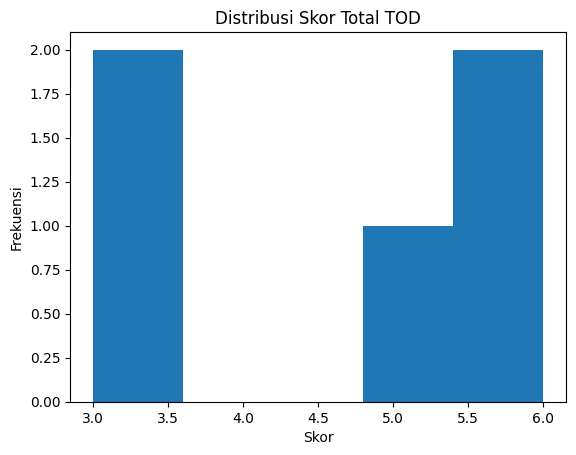

In [17]:
result["SKOR_TOTAL"].plot(kind="hist", bins=5)

plt.title("Distribusi Skor Total TOD")
plt.xlabel("Skor")
plt.ylabel("Frekuensi")
plt.show()

Luas Area TOD

In [22]:
result_meter = result.to_crs(epsg=3857)


In [23]:
result_meter["LUAS_m2"] = result_meter.geometry.area
tabel_luas = result_meter.groupby("KATEGORI_TOD")["LUAS_m2"].sum().reset_index()

tabel_luas


,KATEGORI_TOD,LUAS_m2
0,Tidak Potensial,2.493296e+06
1,Cukup Potensial,1.246506e+06
2,Sangat Potensial,2.493201e+06


In [24]:
tabel_luas["LUAS_ha"] = tabel_luas["LUAS_m2"] / 10000

tabel_luas

,KATEGORI_TOD,LUAS_m2,LUAS_ha
0,Tidak Potensial,2.493296e+06,249.329642
1,Cukup Potensial,1.246506e+06,124.650551
2,Sangat Potensial,2.493201e+06,249.320103


Rata-rata Harga Lahan TOD

In [26]:
rata_harga = result.groupby("KATEGORI_TOD")["HARGA_LAHAN"].mean().reset_index()

rata_harga
rata_harga["HARGA_JUTA"] = rata_harga["HARGA_LAHAN"] / 1000000

rata_harga

,KATEGORI_TOD,HARGA_LAHAN,HARGA_JUTA
0,Tidak Potensial,287500000.0,287.5
1,Cukup Potensial,250000000.0,250.0
2,Sangat Potensial,195000000.0,195.0
